In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width: 98% }<\style>")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
activities_train = pd.read_csv('../data/act_train.csv.zip', index_col='activity_id', parse_dates=['date'])
activities_test = pd.read_csv('../data/act_test.csv.zip', index_col='activity_id', parse_dates=['date'])
people = pd.read_csv('../data/people.csv.zip', parse_dates=['date'])

In [4]:
print('People from train: ', activities_train.people_id.unique().size)
print('People from test: ', activities_test.people_id.unique().size)

print('People from intersection: ', np.intersect1d(activities_train.people_id.unique(), 
                                                   activities_test.people_id.unique()).size)

People from train:  151295
People from test:  37823
People from intersection:  0


In [5]:
people_from_train = activities_train.people_id.unique()
people_from_test = activities_test.people_id.unique()

people_from_void = people.people_id[~people.people_id.isin(np.hstack((people_from_train, people_from_test)))].values

print('People from void:', people_from_void.size)

People from void: 0


In [6]:
train = pd.merge(activities_train[['people_id', 'outcome', 'date']], 
                 people[['people_id', 'group_1', 'char_2']], 
                 on='people_id', 
                 right_index=True)

test = pd.merge(activities_test[['people_id', 'date']], 
                 people[['people_id', 'group_1', 'char_2']], 
                 on='people_id', 
                 right_index=True)

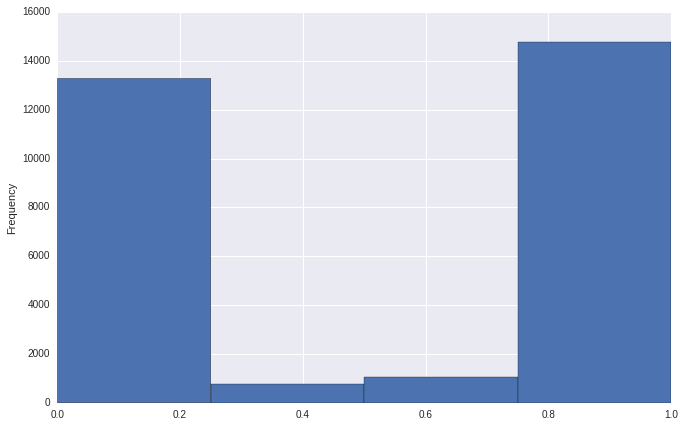

In [47]:
train.groupby('group_1')['outcome'].mean().plot.hist(figsize=(11, 7), bins=4)

In [55]:
print('Groups from train: ', train.group_1.unique().size) 
print('Groups from test: ', test.group_1.unique().size)
print('Groups from intersection: ', np.intersect1d(test.group_1.unique(), train.group_1.unique()).size) 

Groups from train:  29899
Groups from test:  11640
Groups from intersection:  7315


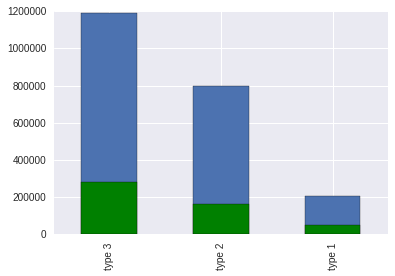

In [70]:
train.char_2.value_counts().plot.bar()
test.char_2.value_counts().plot.bar(color='green')

In [62]:
train.groupby('char_2')['outcome'].mean()

char_2
type 1    0.690992
type 2    0.000000
type 3    0.698855
Name: outcome, dtype: float64

In [10]:
from misc import encode_cat_feature_using_targets, make_submission
from sklearn.metrics import roc_auc_score

for default_prob in np.linspace(0.1, 0.5, 10):
    encoded_group_1 = encode_cat_feature_using_targets(train.group_1, 
                                                       train.outcome, 
                                                       test.group_1, 
                                                       default_prob=default_prob, 
                                                       n_folds=5, random_state=45)
    make_submission(encoded_group_1, path='../submissions/only_group_1_submission.csv', index=test.index, name='outcome')

    auc = roc_auc_score(train.outcome, encoded_group_1)
    
    print('Prob = {prob}, AUC = {auc}'.format(prob=default_prob, auc=auc))

Prob = 0.1, AUC = 0.9708361531367453
Prob = 0.14444444444444446, AUC = 0.9709311935633832
Prob = 0.18888888888888888, AUC = 0.9711062949826639
Prob = 0.23333333333333334, AUC = 0.9713048112365088
Prob = 0.2777777777777778, AUC = 0.9713135928440594
Prob = 0.32222222222222224, AUC = 0.9712793182002095
Prob = 0.3666666666666667, AUC = 0.9712560008220182
Prob = 0.4111111111111111, AUC = 0.9711336771727526
Prob = 0.4555555555555556, AUC = 0.970931458514769
Prob = 0.5, AUC = 0.970723807641881
